# Bicycle Commuting Data

In [9]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

The data used for the analysis was taken from three datasets of Mexico City's government [website](https://datos.cdmx.gob.mx/):

| Dataset                         | Location    | Date of download |
| ------------------------------- | ------------------------------------------------------------ | ---------------- |
| Bicycle counter                 | https://datos.cdmx.gob.mx/dataset/contador-ciclistas         | 11-Dec-2020      |
| Road accidents                  | https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5       | 11-Dec-2020      |
| Estudio de Conteo ciclista 2018 | https://datos.cdmx.gob.mx/dataset/estudio-de-conteo-ciclista-2018 | 11-Dec-2020      |

I have already downloaded them in the /Data directory, so let's import them.

In [10]:
contador = pd.read_csv('Data/contador-ciclistas.csv')
incidentes = pd.read_csv('Data/incidentes-viales-c5.csv')
estudio = pd.read_csv('Data/estudio-de-conteo-ciclista-2018.csv')

## 1. Bicycle counter

### Data exploration

In [11]:
contador.head()

,Id,dia_de_la_semana,dia,mes,ano,contador_ruta_reforma222,contador_ruta_revolucion,contador_ruta_patriotismo
0,1,jueves,5,diciembre,2013,2516.0,NaN,NaN
1,2,lunes,9,diciembre,2013,2132.0,NaN,NaN
2,3,viernes,22,junio,2018,2913.0,980.0,1163.0
3,4,martes,10,julio,2018,2531.0,877.0,1013.0
4,5,sábado,7,julio,2018,1534.0,616.0,584.0


In [12]:
contador.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         2525 non-null   int64  
 1   dia_de_la_semana           2525 non-null   object 
 2   dia                        2525 non-null   int64  
 3   mes                        2525 non-null   object 
 4   ano                        2525 non-null   int64  
 5   contador_ruta_reforma222   2150 non-null   float64
 6   contador_ruta_revolucion   1533 non-null   float64
 7   contador_ruta_patriotismo  1537 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 157.9+ KB


In [13]:
contador.isnull().sum()

Id                             0
dia_de_la_semana               0
dia                            0
mes                            0
ano                            0
contador_ruta_reforma222     375
contador_ruta_revolucion     992
contador_ruta_patriotismo    988
dtype: int64

It seems that the counters didn't start recolecting data at the same time. We should see when did each start by  visualizing where exactly are the null values. However, the dataset is not ordered by date, so let's transform the dates to a datetime format.

### Data cleaning

In [14]:
#Drop id column
contador.drop('Id', axis=1, inplace=True)

In [15]:
# Change column names
contador.columns

Index(['dia_de_la_semana', 'dia', 'mes', 'ano', 'contador_ruta_reforma222',
       'contador_ruta_revolucion', 'contador_ruta_patriotismo'],
      dtype='object')

In [16]:
contador.columns = ['Día de la semana', 'Día', 'Mes', 'Año', 'Reforma', 'Revolución', 'Patriotismo']

In [17]:
# Transform months to categories to order them.
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
contador['Mes'] = pd.Categorical(contador['Mes'], meses)

# Order values in descending order.
contador = contador.sort_values(['Año', 'Mes', 'Día'])

# Change months back to object type
contador['Mes'] = contador['Mes'].astype('object')

In [18]:
# Label-encode months
dict_meses = {}
number = 0
for mes in meses: 
    number += 1
    dict_meses[mes] = number
    
contador['Mes'] = contador['Mes'].map(dict_meses)

In [19]:
# Create new column with complete date
contador.insert(4, 'Fecha', pd.to_datetime(contador.Año*10000+contador.Mes*100+contador.Día, format='%Y%m%d'))

In [20]:
# Reset indexes
contador = contador.reset_index(drop=True)

In [21]:
contador.head(4)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
0,sábado,16,11,2013,2013-11-16,613.0,NaN,NaN
1,domingo,17,11,2013,2013-11-17,1084.0,NaN,NaN
2,lunes,18,11,2013,2013-11-18,1073.0,NaN,NaN
3,martes,19,11,2013,2013-11-19,1344.0,NaN,NaN


In [22]:
# Change months back to string format
dict_meses_inverso = {}
for mes, numero in dict_meses.items():
    dict_meses_inverso[numero] = mes
    
contador['Mes'] = contador['Mes'].map(dict_meses_inverso)

In [23]:
# Replace special characters
contador['Día de la semana'] = contador['Día de la semana'].str.replace('á', 'a').str.replace('é', 'e')

Now that we have a clean and ordered dataset, we can visualize the distribution of null values.

In [24]:
# Create dictionary with column types.
def recognize_column_type(dtf, col, max_cat=20):
    """Returns the type of a column"""
    
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

dic_cols = {col:recognize_column_type(contador, col, max_cat=20) for col in contador.columns}

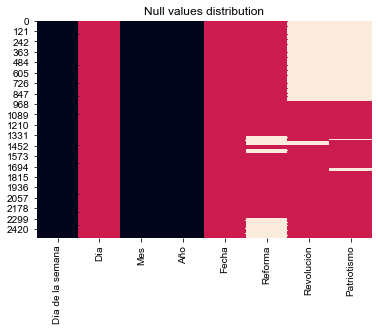

 Categorical   Numeric   NaN 


In [25]:
# Visualize data
heatmap = contador.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
        
sns.heatmap(heatmap, cbar=False).set_title('Null values distribution')
sns.set(rc={'figure.figsize':(10,5)});
plt.show()
print("\033[1;37;40m Categorical ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

It appears that the Reforma counter started much sooner than the other two. However, in recent months, the counter in Reforma stopped. 

In [26]:
contador.head(1)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
0,sabado,16,noviembre,2013,2013-11-16,613.0,NaN,NaN


In [19]:
contador[contador['Revolución'].notnull()].head(4)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
941,martes,14,junio,2016,2016-06-14,2884.0,333.0,256.0
942,miercoles,15,junio,2016,2016-06-15,2909.0,864.0,993.0
943,jueves,16,junio,2016,2016-06-16,283.0,855.0,901.0
944,viernes,17,junio,2016,2016-06-17,2695.0,889.0,856.0


**The Reforma counter started in 16 Nov 2013**. Afterward, **the counters for avenue Revolución and Patriotismo were installed in 14 June 2016**. Later, the Reforma counter stopped. To see exactly when, let's visualize the data with a line graph:

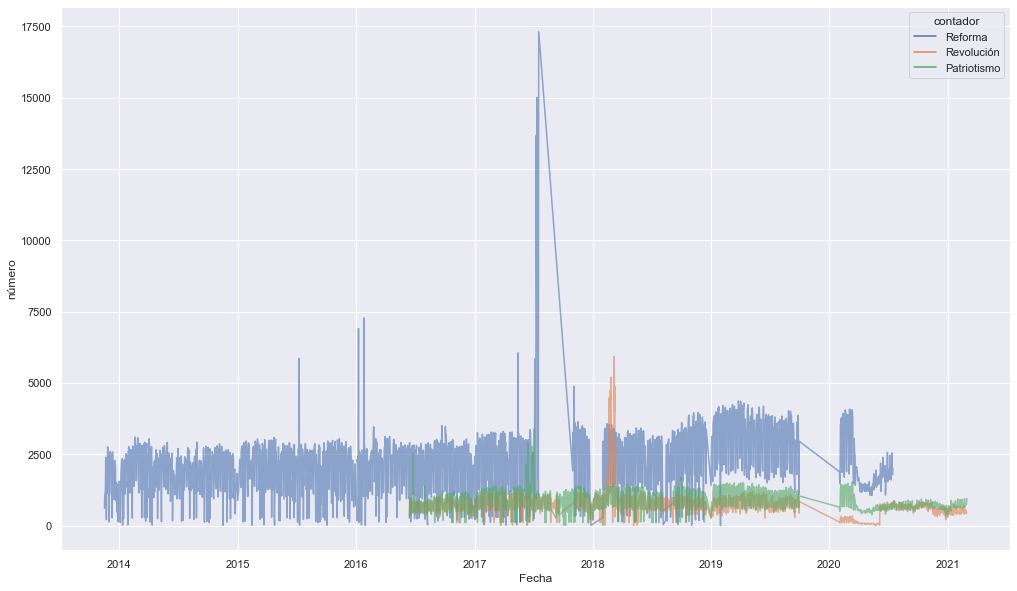

In [40]:
sns.set_theme()
data_lineplot = pd.melt(contador[['Fecha', 'Reforma', 'Revolución', 'Patriotismo']], 'Fecha', var_name='contador', value_name='número')
sns.lineplot(x='Fecha', y='número', hue='contador', data=data_lineplot, alpha=0.6)

#Change figure size
sns.set(rc={'figure.figsize':(17,10)});

There are strange gaps in the data shown in the line chart, which seaborn fills with a line, connecting the last available data point with the next available one. They probably shown gaps in our data.

Here we confirm various things:
- The Reforma counter started much earlier than the other two. 
- There is some missing data in the Reforma counter, and to a smaller extent in the Revolución counter, between 2017-2018.
- The Reforma counter stopped abruptly at mid 2020.

Moreover, we discover some new insights:
- There is some missing data in all counters at the end of 2019 (which the previous chart did not show).
- The lines fluctuate, probably because there is a difference in the day-to-day usage of bicycles.
- There was a big spike in the Reforma and Patriotismo counters just before we get a gap in our data. Then, we see a spike in the Revolución data. Was there some sort of holiday?

Let's dig into the missing data towards the end of 2019. We can create two line charts, from 2019 and 2020, to figure out what is going on:

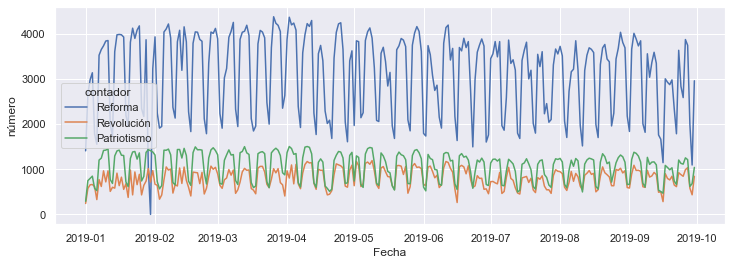

In [44]:
data_lineplot2 = pd.melt(contador.loc[contador['Año'] == 2019,['Fecha', 'Reforma', 'Revolución', 'Patriotismo']], 'Fecha', var_name='contador', value_name='número')
sns.lineplot(x='Fecha', y='número', hue='contador', data=data_lineplot2)

#Change figure size
sns.set(rc={'figure.figsize':(12,4)});

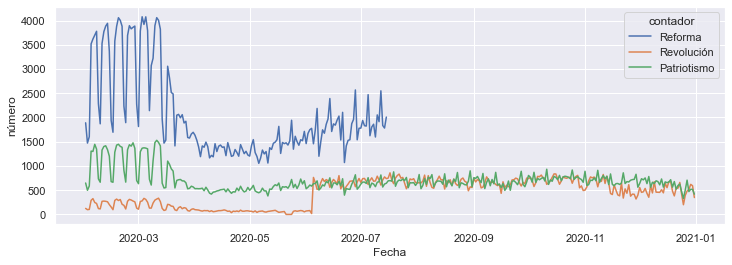

In [45]:
data_lineplot2 = pd.melt(contador.loc[contador['Año'] == 2020,['Fecha', 'Reforma', 'Revolución', 'Patriotismo']], 'Fecha', var_name='contador', value_name='número')
sns.lineplot(x='Fecha', y='número', hue='contador', data=data_lineplot2)

#Change figure size
sns.set(rc={'figure.figsize':(12,4)});

Both of the previous chart do not display data for all months. The one from 2019 stops at October, and the one from 2020 begins in March. Arguably, this is because we have missing data. Let's see the raw data:

In [56]:
start_date = '2019-09-15'
end_date = '2020-03-01'
contador.loc[(contador.Fecha >= start_date) & (contador.Fecha <= end_date)].head(60)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
2115,domingo,15,septiembre,2019,2019-09-15,1662.0,498.0,506.0
2116,lunes,16,septiembre,2019,2019-09-16,1145.0,283.0,468.0
2117,martes,17,septiembre,2019,2019-09-17,3000.0,901.0,1084.0
2118,miercoles,18,septiembre,2019,2019-09-18,2923.0,795.0,1038.0
2119,jueves,19,septiembre,2019,2019-09-19,2870.0,763.0,987.0
2120,viernes,20,septiembre,2019,2019-09-20,2976.0,845.0,1032.0
2121,sabado,21,septiembre,2019,2019-09-21,2341.0,650.0,738.0
2122,domingo,22,septiembre,2019,2019-09-22,1784.0,614.0,662.0
2123,lunes,23,septiembre,2019,2019-09-23,3630.0,923.0,1203.0
2124,martes,24,septiembre,2019,2019-09-24,2833.0,880.0,1129.0


Indeed, **we do not have data on any counter from October 2020 to 31 January 2021**. It did not show on one of our earlier graphs because the date rows are not even present on the dataset.

Now let's look at when the Reforma counter stopped working:

In [33]:
contador.loc[(contador.Año >= 2020) & (contador['Reforma'].isnull())].head(4)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
2297,jueves,16,julio,2020,2020-07-16,NaN,749.0,693.0
2298,viernes,17,julio,2020,2020-07-17,NaN,858.0,697.0
2299,sabado,18,julio,2020,2020-07-18,NaN,706.0,686.0
2300,domingo,19,julio,2020,2020-07-19,NaN,634.0,878.0


**The Reforma counter stopped on July 2020**.

Finally, let's investigate the spikes in the graph:

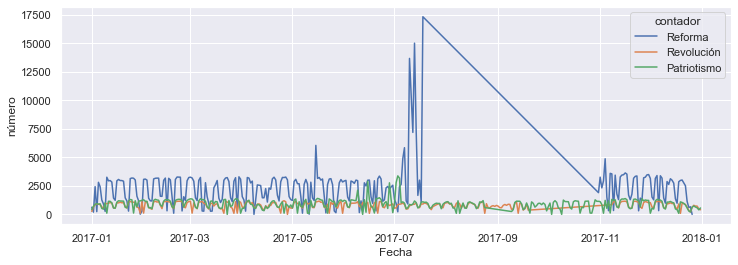

In [57]:
data_lineplot2 = pd.melt(contador.loc[contador['Año'] == 2017,['Fecha', 'Reforma', 'Revolución', 'Patriotismo']], 'Fecha', var_name='contador', value_name='número')
sns.lineplot(x='Fecha', y='número', hue='contador', data=data_lineplot2)

#Change figure size
sns.set(rc={'figure.figsize':(12,4)});

In [59]:
start_date = '2017-07-01'
end_date = '2017-11-01'
contador.loc[(contador.Fecha >= start_date) & (contador.Fecha <= end_date)].head(30)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
1323,sabado,1,julio,2017,2017-07-01,1327.0,556.0,913.0
1324,domingo,2,julio,2017,2017-07-02,971.0,579.0,2794.0
1325,lunes,3,julio,2017,2017-07-03,235.0,863.0,3384.0
1326,martes,4,julio,2017,2017-07-04,2442.0,893.0,3184.0
1327,miercoles,5,julio,2017,2017-07-05,2642.0,928.0,1027.0
1328,jueves,6,julio,2017,2017-07-06,4899.0,991.0,1107.0
1329,viernes,7,julio,2017,2017-07-07,5854.0,881.0,996.0
1330,sabado,8,julio,2017,2017-07-08,1199.0,475.0,508.0
1331,domingo,9,julio,2017,2017-07-09,924.0,493.0,595.0
1332,lunes,10,julio,2017,2017-07-10,13676.0,757.0,884.0


In the **Reforma counter**, the clear outliers are the values for July 10 (Monday), 11 (Tuesday), 13 (Thursday), and 18 (Tuesday), all of which had more than 10,000 records. In contrast, by looking at the graph, the average for that year seems to be around 2,400.

It's strange that there were so many records on those weekdays. There does not seem to be a pattern, such as a weekend plus holidays. Also, I searched on the internet for any cicling news on those days, and I couldn't find any. I also checked is an account on Twitter that posts about cycling in Mexico City (@arelibiciteka), and there doesn't seem to be any uncommon events, except for a protest, but it was on July 17th. (To search for tweets in those specific dates, use *from:arelibiciteka since:2017-07-09 until:2017-07-18*).

My guess is that the counter was not working properly and maybe that's why it abruptly stopped in a few days later. In any case, we should handle these outlier values, even if they are correct, because are not representative of the average records on the counter.

In the **Patriotismo counter**, the outliers were in July 2 (Sunday), 3 (Monday), and 4 (Tuesday), all of which had more than 2,500 records. In contrast, the average for that year seems to be around 1,000.

In contrast to the Reforma counter outliers, there seems to be a pattern in these values. The most likely explanation for these values is that there was a weekend plus holidays. For that reason, we can keep these values.

### Outlier Values

Let's start, then, by replacing the outliers in the Reforma counter. I will use the mean of the past month's corresponding day. So, for example, if a value is missing on Tuesday of July 2020 , I will replace it with the average of all Tuesdays from June 2017. I believe this gives us the best approximation. 

In [78]:
# Calculate mean of the past month's corresponding day
contador[(contador.Año == 2017) & (contador.Mes == 'junio')].groupby(['Mes', 'Día de la semana'])['Reforma'].mean()

Mes    Día de la semana
junio  domingo             1157.50
       jueves              2947.00
       lunes               2129.75
       martes              2104.50
       miercoles           2644.00
       sabado              1099.25
       viernes             2929.60
Name: Reforma, dtype: float64

In [92]:
# Show outlier values
contador.loc[contador.Fecha.isin(['2017-07-10', '2017-07-11', '2017-07-13', '2017-07-18'])]

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
1332,lunes,10,julio,2017,2017-07-10,1.0,757.0,884.0
1333,martes,11,julio,2017,2017-07-11,10391.0,819.0,839.0
1335,jueves,13,julio,2017,2017-07-13,15012.0,900.0,1187.0
1340,martes,18,julio,2017,2017-07-18,17327.0,914.0,1111.0


In [93]:
# Replace outlier values
contador.loc[contador.Fecha == '2017-07-10', 'Reforma'] = 2129.75
contador.loc[contador.Fecha == '2017-07-11', 'Reforma'] = 2104.50
contador.loc[contador.Fecha == '2017-07-13', 'Reforma'] = 2947.00
contador.loc[contador.Fecha == '2017-07-18', 'Reforma'] = 2104.50

In [94]:
# Show outlier values
contador.loc[contador.Fecha.isin(['2017-07-10', '2017-07-11', '2017-07-13', '2017-07-18'])]

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
1332,lunes,10,julio,2017,2017-07-10,2129.75,757.0,884.0
1333,martes,11,julio,2017,2017-07-11,2104.50,819.0,839.0
1335,jueves,13,julio,2017,2017-07-13,2947.00,900.0,1187.0
1340,martes,18,julio,2017,2017-07-18,2104.50,914.0,1111.0


### Missing values

INSERT MISSING ROWS

Now we have to deal with the **missing values**. The values for Revolución and Patriotismo up to 14 June 2016 are simple: we could replace them with a cero, since cero bicycles were, in a way, counted by the counters.

In [23]:
# Fill missing values up to the installation of the counters.
contador.loc[0:940, ['Revolución', 'Patriotismo']] = contador.loc[0:940, ['Revolución', 'Patriotismo']].fillna(0)

For the other ones, let's look at them more closely:

In [24]:
contador[contador['Reforma'].isnull()].head()

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
1341,miercoles,19,julio,2017,2017-07-19,NaN,1017.0,1061.0
1342,jueves,20,julio,2017,2017-07-20,NaN,959.0,1081.0
1343,viernes,21,julio,2017,2017-07-21,NaN,878.0,963.0
1344,sabado,22,julio,2017,2017-07-22,NaN,627.0,558.0
1345,domingo,23,julio,2017,2017-07-23,NaN,423.0,580.0


In [25]:
contador.iloc[1336:1346, :]

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
1336,viernes,14,julio,2017,2017-07-14,7291.0,1007.0,1041.0
1337,sabado,15,julio,2017,2017-07-15,1674.0,629.0,571.0
1338,domingo,16,julio,2017,2017-07-16,3013.0,600.0,679.0
1339,lunes,17,julio,2017,2017-07-17,1061.0,926.0,1077.0
1340,martes,18,julio,2017,2017-07-18,17327.0,914.0,1111.0
1341,miercoles,19,julio,2017,2017-07-19,NaN,1017.0,1061.0
1342,jueves,20,julio,2017,2017-07-20,NaN,959.0,1081.0
1343,viernes,21,julio,2017,2017-07-21,NaN,878.0,963.0
1344,sabado,22,julio,2017,2017-07-22,NaN,627.0,558.0
1345,domingo,23,julio,2017,2017-07-23,NaN,423.0,580.0


It is unlikely that cyclists simply stoped passing through Reforma, since they were passing through the other counters. Also, the period is too long for it to overlap with, say, a holiday. My hypothesis is that the counter simply stoped working for some reason.

The same is probably happening for the final values of the Reforma counter:

In [26]:
contador[contador['Reforma'].notnull()].tail()

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
2292,sabado,11,julio,2020,2020-07-11,1913.0,710.0,674.0
2293,domingo,12,julio,2020,2020-07-12,2550.0,605.0,814.0
2294,lunes,13,julio,2020,2020-07-13,1835.0,711.0,565.0
2295,martes,14,julio,2020,2020-07-14,1782.0,774.0,627.0
2296,miercoles,15,julio,2020,2020-07-15,2008.0,738.0,643.0


In [27]:
contador.iloc[2293:2304, :]

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
2293,domingo,12,julio,2020,2020-07-12,2550.0,605.0,814.0
2294,lunes,13,julio,2020,2020-07-13,1835.0,711.0,565.0
2295,martes,14,julio,2020,2020-07-14,1782.0,774.0,627.0
2296,miercoles,15,julio,2020,2020-07-15,2008.0,738.0,643.0
2297,jueves,16,julio,2020,2020-07-16,NaN,749.0,693.0
2298,viernes,17,julio,2020,2020-07-17,NaN,858.0,697.0
2299,sabado,18,julio,2020,2020-07-18,NaN,706.0,686.0
2300,domingo,19,julio,2020,2020-07-19,NaN,634.0,878.0
2301,lunes,20,julio,2020,2020-07-20,NaN,750.0,581.0
2302,martes,21,julio,2020,2020-07-21,NaN,802.0,676.0


Indeed, the counter stops abruptly, while the other counters keep going without any problem. 

INSERT THE MISSING DATE ROWS. 

To handle these missing value, I will use the **mean of the past month's corresponding day**. So, for example, if a value is missing on Sunday of July 2020 , I will replace it with the average of all Sundays from June 2020. I believe this gives us the best approximation. 

I discarded other alternatives because:
- Using the _global average or the mode_ would be misleading, since the number of cyclists over time will probably fluctuate.
- _Dropping_ the missing values would alter the total cyclists in a given year since the nulls are clustered in certain areas.
- Using a _forward fill_ (that is, populating with the last valid observation) would be innaccurate, since each day will probably have different number of cyclists (see graph below). Also, in the previous linechart, we saw a spike in the counter just before the missing values, so it would populate with this outlier values. 

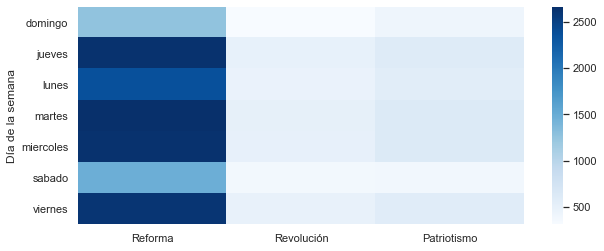

In [28]:
sns.heatmap(contador.groupby('Día de la semana')[['Reforma', 'Revolución', 'Patriotismo']].mean(), cmap='Blues');

Indeed, weekends tend to be much less crowded.
Therefore, let's use the mean of the past month's corresponding day.

In [29]:
# Calculate mean of each day of each month and year. 
means = pd.DataFrame(contador.groupby([ 'Año', 'Mes', 'Día de la semana'])['Reforma' ,'Revolución', 'Patriotismo'].mean()).sort_index().reset_index()
means

<ipython-input-29-7d520ddacd05>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  means = pd.DataFrame(contador.groupby([ 'Año', 'Mes', 'Día de la semana'])['Reforma' ,'Revolución', 'Patriotismo'].mean()).sort_index().reset_index()


,Año,Mes,Día de la semana,Reforma,Revolución,Patriotismo
0,2013,diciembre,domingo,1004.00,0.00,0.00
1,2013,diciembre,jueves,2044.00,0.00,0.00
2,2013,diciembre,lunes,1916.40,0.00,0.00
3,2013,diciembre,martes,1530.20,0.00,0.00
4,2013,diciembre,miercoles,1984.25,0.00,0.00
...,...,...,...,...,...,...
583,2021,febrero,lunes,NaN,482.25,627.75
584,2021,febrero,martes,NaN,481.50,708.50
585,2021,febrero,miercoles,NaN,446.75,716.00
586,2021,febrero,sabado,NaN,460.00,772.25


In [30]:
contador.head(3)

,Día de la semana,Día,Mes,Año,Fecha,Reforma,Revolución,Patriotismo
0,sabado,16,noviembre,2013,2013-11-16,613.0,0.0,0.0
1,domingo,17,noviembre,2013,2013-11-17,1084.0,0.0,0.0
2,lunes,18,noviembre,2013,2013-11-18,1073.0,0.0,0.0


In [31]:
# Define list of months and counters
months = ['enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre',
 'diciembre']
counters = ['Reforma', 'Revolución', 'Patriotismo']

The following block of code substitutes the missing values. However, we should be wary of using any means in the month of July 2017, since we got outlier values in that month. For those cases, we could use the values for June 2017.

In [32]:
# Fill missing values with the mean of the past month's corresponding day.
for counter in counters:
    for i in contador.index.tolist():
        if pd.isnull(contador.loc[i, counter]):
            # Get current date
            day = contador['Día de la semana'][i]
            month = contador['Mes'][i]
            year = contador['Año'][i]

            # Get mean of last available month.
            mean_last_available_month = np.NaN
            index_adjuster = 0
            while pd.isnull(mean_last_available_month):
                # Get past month and its year
                index_adjuster -= 1
                last_available_month = months[months.index(month)+index_adjuster]
                year_last_available_month = year

                if last_available_month == 'diciembre':
                    year_last_available_month -= 1

                ### Avoid outlier values from July 2017
                if last_available_month == 'julio':
                    index_adjuster -= 1
                    last_available_month = months[months.index(month)+index_adjuster]

                # Get mean of past month
                mean_last_available_month = means.loc[(means.Año == year_last_available_month) & (means.Mes == last_available_month) & (means['Día de la semana'] == day), counter].iloc[0]         

            # Assign value to cell 
            contador.loc[i, counter] = mean_last_available_month

            # Print value assigned to cell
            print(f'- Value: {mean_last_available_month} | {counter} | {i} | Year: {year_last_available_month} | Av. Month: {last_available_month} | Month: {month} | Day: {day}')
            
            
except:
    I

- Value: 2644.0 | Reforma | 1341 | Year: 2017 | Av. Month: junio | Month: julio | Day: miercoles
- Value: 2947.0 | Reforma | 1342 | Year: 2017 | Av. Month: junio | Month: julio | Day: jueves
- Value: 2929.6 | Reforma | 1343 | Year: 2017 | Av. Month: junio | Month: julio | Day: viernes
- Value: 1099.25 | Reforma | 1344 | Year: 2017 | Av. Month: junio | Month: julio | Day: sabado
- Value: 1157.5 | Reforma | 1345 | Year: 2017 | Av. Month: junio | Month: julio | Day: domingo
- Value: 2129.75 | Reforma | 1346 | Year: 2017 | Av. Month: junio | Month: julio | Day: lunes
- Value: 2104.5 | Reforma | 1347 | Year: 2017 | Av. Month: junio | Month: julio | Day: martes
- Value: 2644.0 | Reforma | 1348 | Year: 2017 | Av. Month: junio | Month: julio | Day: miercoles
- Value: 2947.0 | Reforma | 1349 | Year: 2017 | Av. Month: junio | Month: julio | Day: jueves
- Value: 2929.6 | Reforma | 1350 | Year: 2017 | Av. Month: junio | Month: julio | Day: viernes
- Value: 1099.25 | Reforma | 1351 | Year: 2017 | A

- Value: 2929.6 | Reforma | 1441 | Year: 2017 | Av. Month: junio | Month: octubre | Day: viernes
- Value: 1099.25 | Reforma | 1442 | Year: 2017 | Av. Month: junio | Month: octubre | Day: sabado
- Value: 1157.5 | Reforma | 1443 | Year: 2017 | Av. Month: junio | Month: octubre | Day: domingo
- Value: 2129.75 | Reforma | 1444 | Year: 2017 | Av. Month: junio | Month: octubre | Day: lunes
- Value: 3426.4 | Reforma | 1502 | Year: 2017 | Av. Month: noviembre | Month: diciembre | Day: miercoles
- Value: 2639.4 | Reforma | 1503 | Year: 2017 | Av. Month: noviembre | Month: diciembre | Day: jueves
- Value: 2564.75 | Reforma | 1504 | Year: 2017 | Av. Month: noviembre | Month: diciembre | Day: viernes
- Value: 2454.0 | Reforma | 1505 | Year: 2017 | Av. Month: noviembre | Month: diciembre | Day: sabado
- Value: 1345.0 | Reforma | 1506 | Year: 2017 | Av. Month: noviembre | Month: diciembre | Day: domingo
- Value: 2398.0 | Reforma | 1507 | Year: 2017 | Av. Month: diciembre | Month: enero | Day: lunes


- Value: 1396.2 | Reforma | 2378 | Year: 2020 | Av. Month: junio | Month: octubre | Day: lunes
- Value: 1644.6 | Reforma | 2379 | Year: 2020 | Av. Month: junio | Month: octubre | Day: martes
- Value: 1715.75 | Reforma | 2380 | Year: 2020 | Av. Month: junio | Month: octubre | Day: miercoles
- Value: 1735.0 | Reforma | 2381 | Year: 2020 | Av. Month: junio | Month: octubre | Day: jueves
- Value: 1804.0 | Reforma | 2382 | Year: 2020 | Av. Month: junio | Month: octubre | Day: viernes
- Value: 1801.75 | Reforma | 2383 | Year: 2020 | Av. Month: junio | Month: octubre | Day: sabado
- Value: 2312.75 | Reforma | 2384 | Year: 2020 | Av. Month: junio | Month: octubre | Day: domingo
- Value: 1396.2 | Reforma | 2385 | Year: 2020 | Av. Month: junio | Month: octubre | Day: lunes
- Value: 1644.6 | Reforma | 2386 | Year: 2020 | Av. Month: junio | Month: octubre | Day: martes
- Value: 1715.75 | Reforma | 2387 | Year: 2020 | Av. Month: junio | Month: octubre | Day: miercoles
- Value: 1735.0 | Reforma | 23

IndexError: single positional indexer is out-of-bounds

By doing a quick scan of the values we used for replacement, there don't appear to be any outliers.

In [ ]:
contador.isnull().sum()

Also, we do not have any missing values. Let's see how our new dataset looks like:

In [ ]:
sns.set_theme()
data_lineplot = pd.melt(contador[['Fecha', 'Reforma', 'Revolución', 'Patriotismo']], 'Fecha', var_name='contador', value_name='número')
sns.lineplot(x='Fecha', y='número', hue='contador', data=data_lineplot)

#Change figure size
sns.set(rc={'figure.figsize':(16,9)});

### Save dataset

In [ ]:
# Create column with total cyclists of a given day
contador['total'] = contador['Patriotismo'] + contador['Revolución'] + contador['Reforma']
contador['total'] = contador['total'].astype('int64')

In [ ]:
# Change column type to integer.
for counter in counters:
    contador[counter] = contador[counter].astype('int64')

In [ ]:
contador.head()

In [ ]:
contador_final = contador.copy()

In [ ]:
contador_final.info()

In [ ]:
contador_final.to_csv('Data/contador_final.csv', index=False)

# 2. Road accidents

### Data exploration

In [ ]:
incidentes.head(4)

Let's work only with the columns that seem relevant for our purposes. 

In [ ]:
incidentes = incidentes[['dia_semana', 'fecha_creacion', 'hora_creacion', 'mes', 'delegacion_inicio', 'latitud', 'longitud', 'geopoint']]

In [ ]:
incidentes.head(4)

In [ ]:
incidentes.info()

We should transform the date and hour columns to a single datetime column. Also, let's see the distribution of hours of the reports, to check whether there are any mistakes.

In [ ]:
incidentes.hora_creacion.value_counts()

All the hours seem to be properly registered. Now let's check the format:

In [ ]:
incidentes.loc[incidentes['hora_creacion'].str.match(r'\d\d:\d\d:\d\d') == False, 'hora_creacion']

We have multiple values that do not have the proper format. Let's see if they represent time expressed as number of seconds, in decimal form. 

In [ ]:
t = "11:12:21"
(h, m, s) = t.split(':')
result = int(h) * 3600 + int(m) * 60 + int(s)
result

No, the numbers we had before are too large to represent seconds. Also, they do not seem to have a distinguishable pattern. Therefore, let's just drop them. 

In [ ]:
len(incidentes)

In [ ]:
incidentes = incidentes[incidentes['hora_creacion'].str.match(r'\d\d:\d\d:\d\d') == True]

In [ ]:
len(incidentes)

Now let's proceed to transform the time columns.

### Data cleaning

In [ ]:
# Clean day column.
incidentes['dia_semana'] = incidentes['dia_semana'].str.lower()

In [ ]:
# Combine date and time columns
fecha_hora = pd.Series(incidentes['fecha_creacion'] + ' ' + incidentes['hora_creacion'])

In [ ]:
# Insert new column
incidentes.insert(1, 'fecha_hora', fecha_hora)

In [ ]:
# Change new column to datetime format
incidentes['fecha_hora'] = pd.to_datetime(incidentes['fecha_hora'], format='%d/%m/%Y %H:%M:%S')

In [ ]:
# Change type of time columns
incidentes['fecha_creacion'] = pd.to_datetime(incidentes['fecha_creacion'], format='%d/%m/%Y')
incidentes['hora_creacion'] = pd.to_datetime(incidentes['hora_creacion'], format='%H:%M:%S').dt.time

In [ ]:
incidentes.info()

In [ ]:
# Drop extra columns
incidentes.drop(['fecha_creacion', 'mes'], axis=1, inplace=True)

# Create new columns with year, month, and hour. 
incidentes.insert(2, 'hora', incidentes['fecha_hora'].dt.hour)
incidentes.insert(2, 'mes', incidentes['fecha_hora'].dt.month)
incidentes.insert(2, 'año', incidentes['fecha_hora'].dt.year)

In [ ]:
incidentes.head(4)

In [ ]:
# Remove special characters
incidentes['dia_semana'] = incidentes['dia_semana'].str.replace('á', 'a').str.replace('é', 'e')

In [ ]:
incidentes.head()

In [ ]:
# Transform months back to text
incidentes['mes'] = incidentes['mes'].map(dict_meses_inverso)

### Save dataset

In [ ]:
incidentes_final = incidentes.copy()

In [ ]:
incidentes_final.to_csv('Data/incidentes_final.csv', index=False)

## 3. Estudio 2018 Ciclismo

### Data exploration

In [ ]:
estudio.head(4)

We have too many columns, so let's expand the default display configuration to analyze them. 

In [ ]:
pd.set_option('display.max_columns', 500)
estudio.head(4)

This dataset is based on a large questionaire and, unfortunately, it is label encoded and abreviated. Therefore, one has to read the [accompanying file](https://github.com/FranciscoGalan/Bicycle_Commuting_Mexico_City/blob/main/Data/Diccionario%20Estudio%20de%20Conteo%20Ciclista%202018.csv) of the dataset, which explains what each label means. 

I already did a preselection of the columns that interest me, so I'll proceed to select them. 

In [ ]:
columnas = ['CALLE_LEV', 'F1', 'P1', 'P3', 'P6', 'P15', 'P18', 'P19', 'P20', 'P21_NIVEL', 'P23_1']
estudio1 = estudio.copy()
estudio1 = estudio1[columnas]

Now, let's change the names of the columns so they are easier to understand.

In [ ]:
# Create dictionary to rename columns
nombres = ['calle_lev', 'edad', 'origen', 'destino', 'motivo_viaje', 'motivo_dejar_bici', 'robado_bici', 'robo_forma', 'sexo', 'educacion', 'ingreso_mensual']
ch_columnas = estudio1.columns.tolist()
res = {ch_columnas[i]: nombres[i] for i in range(len(ch_columnas))}

In [ ]:
# Rename columns
estudio1 = estudio1.rename(columns=res)

We should also remove the label encoding and insert, instead, the textual information.

In [ ]:
# Create dictionaries with number-text answer
dict_origen = {1:'Hogar',
              2:'Trabajo',
              3:'Escuela',
              4:'Centro comercial, tienda, mercado',
              5:'Otra vivienda',
              6:'Restaurante, bar, cafetería',
              7:'Otro',
              98:'No sabe',
              99:'No sabe'}
dict_destino = {1:'Hogar',
              2:'Trabajo',
              3:'Escuela',
              4:'Centro comercial, tienda, mercado',
              5:'Otra vivienda',
              6:'Restaurante, bar, cafetería',
              7:'Otro',
              98:'No sabe',
              99:'No sabe'}
dict_motivo_viaje = {1:'Ir al trabajo',
                    2:'Regreso a casa',
                    3:'Ir a estudiar',
                    4:'Hacer compras',
                    5:'Llevar o recoger a alguien',
                    6:'Recreación',
                    7:'Ir a comer',
                    8:'Relacionado con el trabajo',
                    9:'Trámite',
                    10:'Ir de visita',
                    98:'No sabe',
                    99:'No contestó'}
dict_motivo_dejar_bici = {1:'Lesión o incapacidad',
                         2:'Fala mecánica de bici',
                         3: 'Cambio de trabajo',
                         4: 'Llevar prisa',
                         5: 'Recorrido muy largo',
                         6: 'Falta de infraestructura',
                         7: 'Clima',
                         8: 'Inseguridad',
                         9: 'No haya bici disponible',
                         10: 'Ningún motivo',
                         11: 'No sé',
                         12: 'No contestó'}
dict_robado_bici = {1:'Sí', 2:'No', 8:'No sabe', 9:'No contestó'}
dict_robo_forma = {1:'Estacionada', 2:'En movimiento', 8:'No sabe', 9:'No contestó'}
dict_sexo = {1: 'Hombre', 2:'Mujer'}
dict_educacion = {1:'Ninguno',
                 2:'Preescolar',
                 3:'Primaria',
                 4:'Secundaria',
                 5:'Preparatoria o Bachillerato',
                 6:'Normal',
                 7:'Carrera Técnica',
                 8:'Licenciatura',
                 9:'Maestría',
                 10:'Doctorado',
                 98:'No sabe',
                  99:'No contestó'}
dict_ingreso_mensual = {1:'>1,000',
                       2:'1,001-3,000',
                       3:'3,001-6,000',
                       4:'6,001-10,000',
                       5:'10,001-15000',
                       6:'<15,001',
                       9:'No contestó'}

In [ ]:
# Change values in columns
columns = estudio1.columns[2:].to_list()
dictionaries = [dict_origen, dict_destino, dict_motivo_viaje, dict_motivo_dejar_bici, dict_robado_bici,
              dict_robo_forma, dict_sexo, dict_educacion, dict_ingreso_mensual]

for i in range(len(columns)):
    estudio1[columns[i]] = estudio1[columns[i]].map(dictionaries[i])

In [ ]:
estudio1.head() 

### Save dataset

In [ ]:
estudio_final = estudio1.copy()

In [ ]:
estudio_final.to_csv('Data/estudio_final.csv', index=False)

#### Save dataset of motivo_dejar bici

In [ ]:
a = pd.Series(estudio_final['motivo_dejar_bici'].value_counts())

In [ ]:
a.to_csv('Data/motivo_dejar_final.csv')